# 3장 단순회귀 모형의 추정

3장 단순회귀 모형의 추정과 관련된 실습을 파이썬(python)으로 한다. 데이터와 필요한 파이썬 패키지는 [여기](00.md) 참조.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

마지막 줄은 레티나 디스플레이이면 실행한다.

## 소득과 환경오염

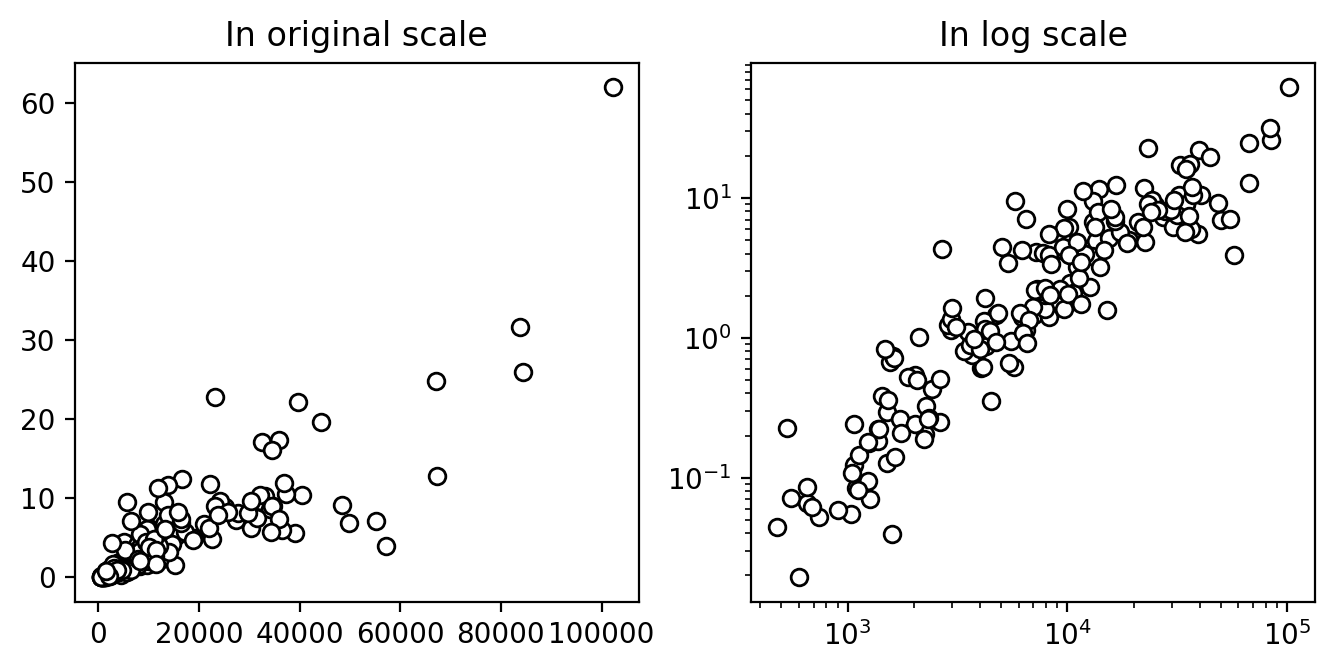

In [2]:
Ekc = pd.read_csv('csv/loedata/Ekc.csv')
fig = plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plt.scatter(Ekc.gdppcppp, Ekc.co2pc, facecolors='w', edgecolors='k')
#plt.plot(Ekc.gdppcppp, Ekc.co2pc, 'o', mfc='none')
plt.title("In original scale")
plt.subplot(1,2,2)
plt.scatter(Ekc.gdppcppp, Ekc.co2pc, facecolors='w', edgecolors='k')
plt.xscale('log')
plt.yscale('log')
plt.title('In log scale')
plt.show()

## 공무원 수 비율과 재정자립도

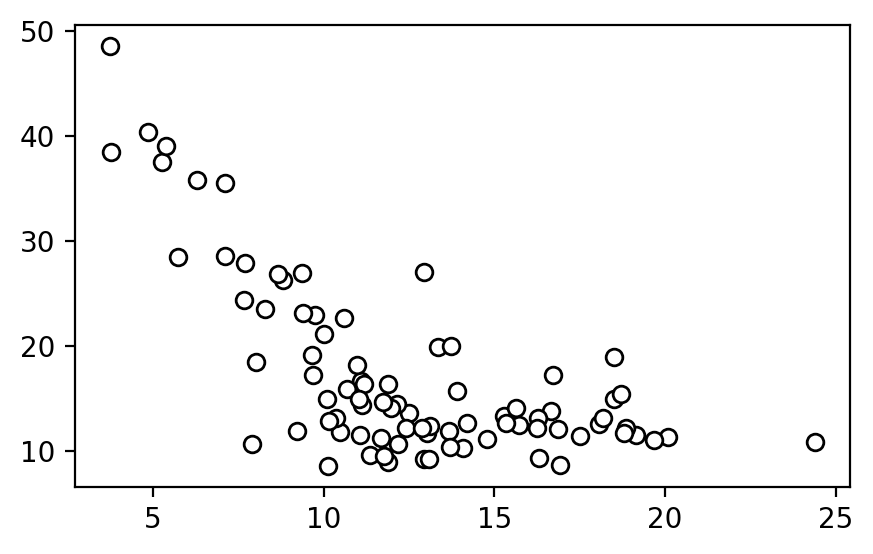

In [3]:
Pubserv = pd.read_csv('csv/loedata/Pubserv.csv')
plt.figure(figsize=(5,3))
Pubserv1 = Pubserv[Pubserv['servpc'] < 28].copy()
plt.scatter(Pubserv1.servpc, Pubserv1.finind, color='w', edgecolors='k')
#plt.plot(Pubserv1.servpc, Pubserv1.finind, 'o', mfc='w')
plt.show()

## 교육수준과 임금

(501, 8)


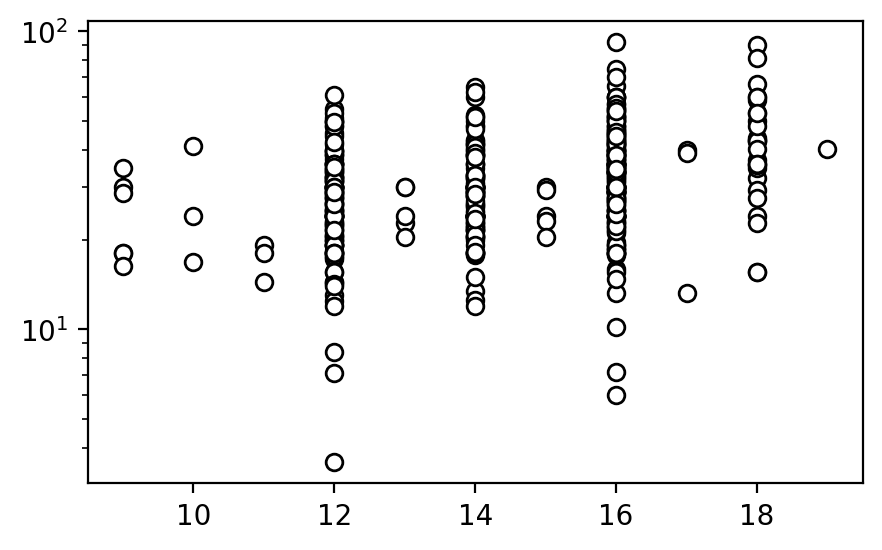

In [4]:
Klips = pd.read_csv('csv/loedata/Klips.csv')
Klips2 = Klips[(Klips['regular']==1) & (Klips['married']==1)].copy()
print(Klips2.shape)
plt.figure(figsize=(5,3))
plt.scatter(Klips2.educ, Klips2.labinc, color='w', edgecolors='k')
#plt.plot(Klips2.educ, Klips2.labinc, 'o', mfc='w')
plt.yscale('log')
plt.show()

In [5]:
Klips2['lnlabinc'] = np.log(Klips2['labinc'])
ave = Klips2[['educ','lnlabinc']].groupby(['educ']).mean(['lnlabinc']).reset_index()
print(ave)

    educ  lnlabinc
0      9  3.145510
1     10  3.239290
2     11  2.837503
3     12  3.262296
4     13  3.223670
5     14  3.342744
6     15  3.223641
7     16  3.476449
8     17  3.312591
9     18  3.693358
10    19  3.696848


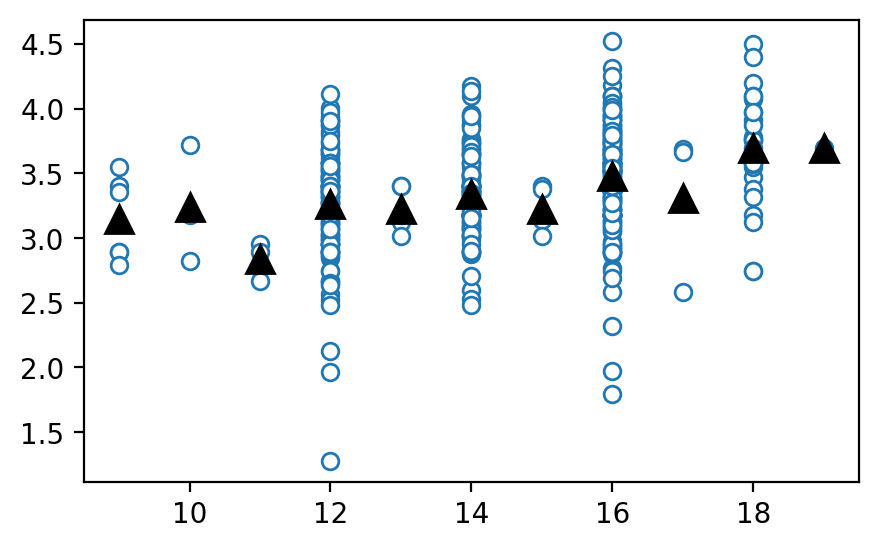

In [6]:
plt.figure(figsize=(5,3))
plt.plot(Klips2.educ, Klips2.lnlabinc, 'o', mfc='w')
plt.plot(ave['educ'], ave['lnlabinc'], '^', color='black', ms=10)
plt.show()

이하에서 산포도에 직선을 덧그릴 것인데, 필자가 실험해 본 바로는 직선을 그리면 산포도의 축이 바뀐다. 그러므로 산포도를 그린 다음에 축을 고정시키는 함수를 만들어서 호출하고자 한다. 다음과 같이 `fix_lims` 함수를 정의하고 앞에서 import한 `plt`의 클래스 함수로 이를 추가한다.

In [7]:
## https://stackoverflow.com/questions/972/adding-a-method-to-an-existing-object-instance
# We need this to fixate the limits of plots
def fix_lims(self):
    self.xlim(self.gca().get_xlim())
    self.ylim(self.gca().get_ylim())

# Now patch plt
plt.fix_lims = fix_lims.__get__(plt)

# 위 method를 만들고 싶지 않으면 plt.fix_lims()를 모두 다음으로 교체
# plt.xlim(plt.gca().get_xlim())
# plt.ylim(plt.gca().get_ylim())

이제 `plt.fix_lims()`을 호출하면 그림의 축이 고정된다.

## 재정자립도 회귀: OLS와 LAD

In [8]:
from statsmodels.api import OLS, QuantReg
fm = 'finind~servpc'
ols = OLS.from_formula(fm, data = Pubserv1).fit()
lad = QuantReg.from_formula(fm, data = Pubserv1).fit(q=0.5)

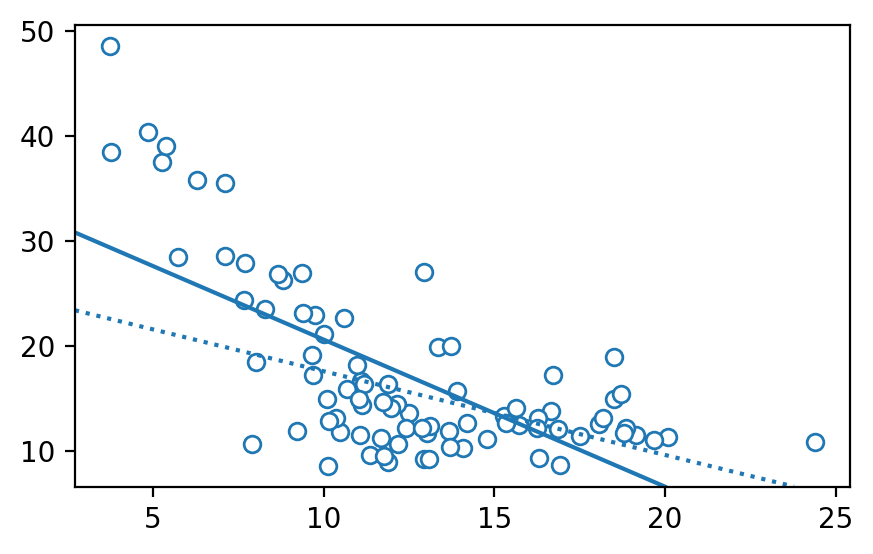

In [9]:
plt.figure(figsize=(5,3))
plt.plot(Pubserv1.servpc, Pubserv1.finind, 'o', mfc='w')
plt.fix_lims()
plt.axline((0, ols.params['Intercept']), slope=ols.params['servpc'])
plt.axline((0, lad.params['Intercept']), slope=lad.params['servpc'], linestyle=':')
plt.show()

## 공무원 수 비율과 재정자립도

In [10]:
import statsmodels.formula.api as smf
ols = smf.ols('np.log(finind)~np.log(servpc)', Pubserv1).fit()
ols.params

Intercept         4.767454
np.log(servpc)   -0.821201
dtype: float64

### 수동으로 계산 확인

위 결과를 수동으로 계산하고자 한다. Python에서 로그를 취하거나 표본평균, 합계 등은 numpy 모듈에 구현되어 있다. 앞에서 numpy를 `np`로 import했으므로 np.log, np.mean, np.sum 등이라고 해야 한다.

In [11]:
x = np.log(Pubserv1.servpc)
y = np.log(Pubserv1.finind)
xbar = np.mean(x)
xd = x-xbar
b1 = np.sum(xd*y)/np.sum(xd**2)
b0 = np.mean(y)-b1*xbar
b0,b1

(4.767453582972257, -0.8212005150740734)

### 데이터와 회귀 직선 그림으로 표시

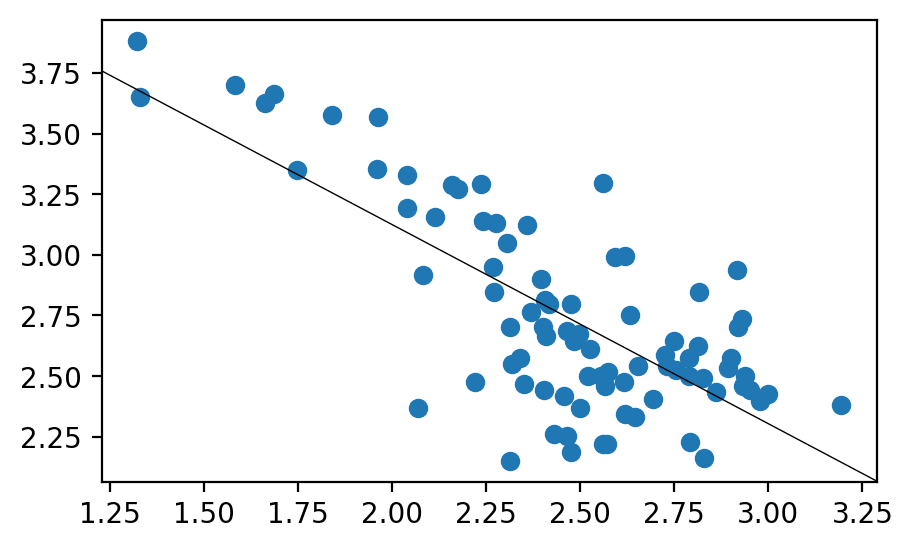

In [12]:
plt.figure(figsize=(5,3))
plt.scatter(x,y)
plt.fix_lims()
plt.axline((0,b0), slope=b1, color='k', lw=0.5)
plt.show()

직선 색깔을 검정색으로 했는데 별다른 이유가 있어서는 아니고, 색깔 줄 때 어떻게 하는지 알아보려고 한번 해 본 것이다.

## 교육수준과 연간 근로소득

In [13]:
import statsmodels.formula.api as smf
ols = smf.ols('np.log(labinc)~educ', data = Klips2).fit()
ols.params

Intercept    2.527273
educ         0.059577
dtype: float64

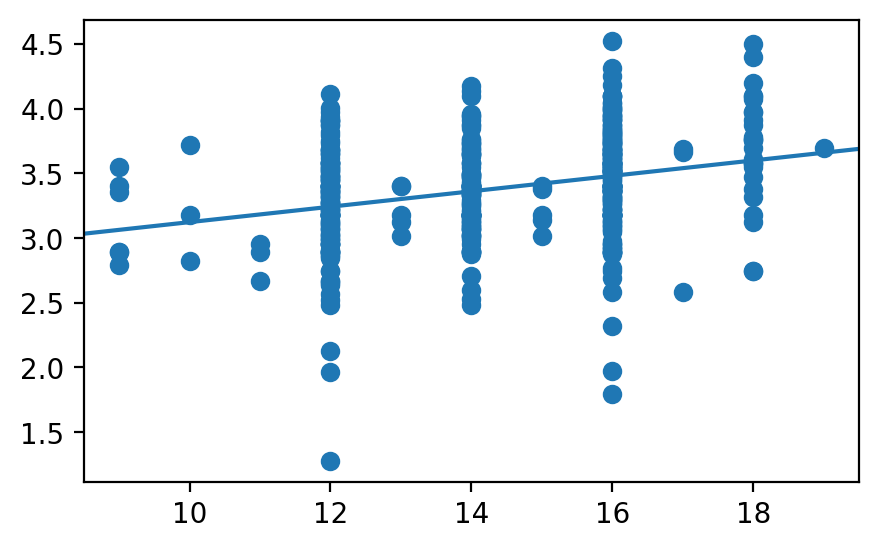

In [14]:
plt.figure(figsize=(5,3))
plt.scatter(Klips2.educ, np.log(Klips2.labinc))
plt.fix_lims() # see above
b0,b1 = ols.params
plt.axline((0,b0), slope = b1)
plt.show()

## 고령인구비율과 흡연율

In [15]:
Death = pd.read_csv('csv/loedata/Death.csv')
Death10 = Death[Death.year==2010].copy()
ols = smf.ols('smoke~aged', data=Death10).fit()
ols.params

Intercept    29.077420
aged         -0.228558
dtype: float64

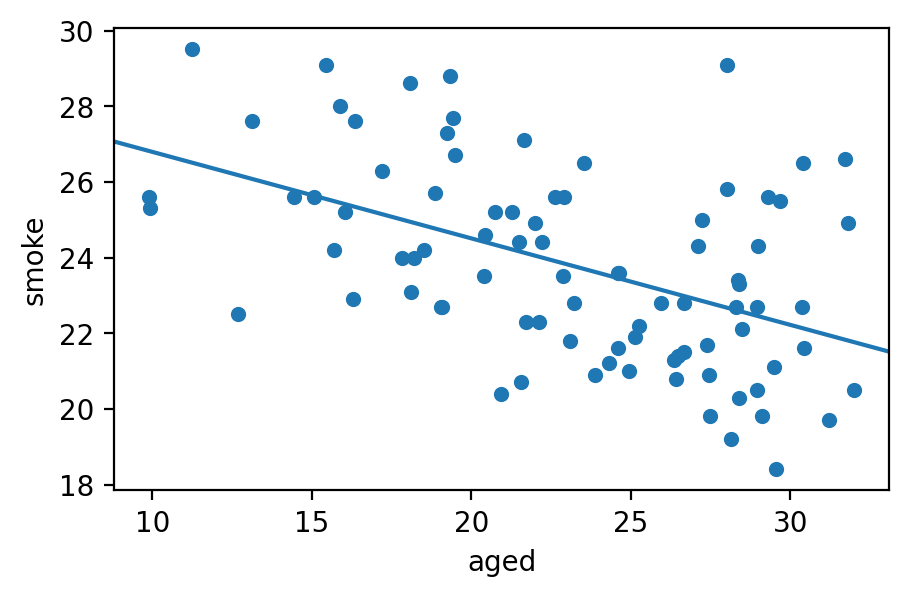

In [16]:
Death10.plot.scatter(x='aged', y='smoke', figsize=(5,3))
plt.fix_lims()
b0,b1 = ols.params
plt.axline((0,b0), slope=b1)
plt.show()
plt.close()

## 소비함수

In [17]:
Consumption = pd.read_csv('csv/Ecdat/Consumption.csv')
ols = smf.ols('ce~yd', data = Consumption).fit()
ols.params

Intercept    6000.256052
yd              0.861788
dtype: float64

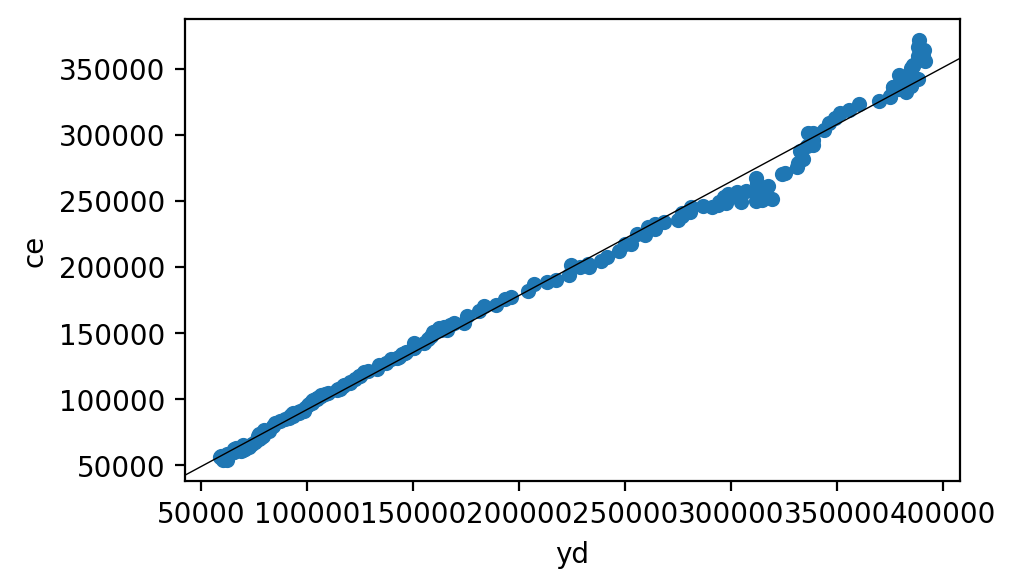

In [18]:
Consumption.plot.scatter(x='yd', y='ce', figsize=(5,3))
plt.fix_lims()
b0,b1 = ols.params
plt.axline((0,b0), slope = b1, color='k', lw=0.5)
plt.show()

## 유전학과 Galton의 "회귀"

In [19]:
Galtonpar = pd.read_csv('csv/loedata/Galtonpar.csv')
ols = smf.ols('avgsonht~midparht', data = Galtonpar).fit()
ols.params

Intercept    21.752799
midparht      0.687150
dtype: float64

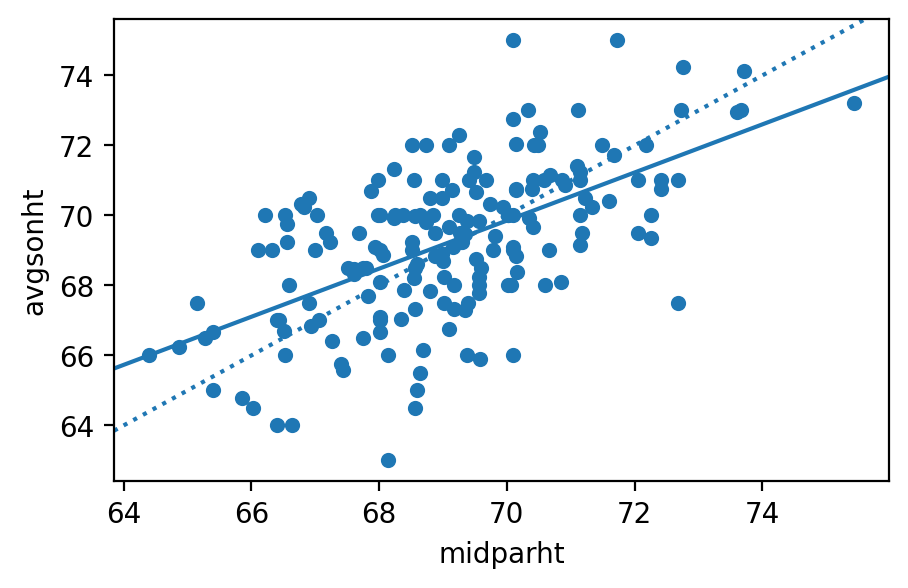

In [20]:
Galtonpar.plot.scatter(x = 'midparht', y = 'avgsonht', figsize=(5,3))
plt.fix_lims()
b0,b1 = ols.params
plt.axline((0,0), slope = 1, linestyle=':')
plt.axline((0,b0), slope = b1)
plt.show()

## 우주의 나이

In [21]:
hubble = pd.read_csv('csv/gamair/hubble.csv')
hubble.head(5)

,Galaxy,y,x
0,NGC0300,133,2.00
1,NGC0925,664,9.16
2,NGC1326A,1794,16.14
3,NGC1365,1594,17.95
4,NGC1425,1473,21.88


In [22]:
ols = smf.ols('y~x-1', data = hubble).fit()
ols.params

x    76.581172
dtype: float64

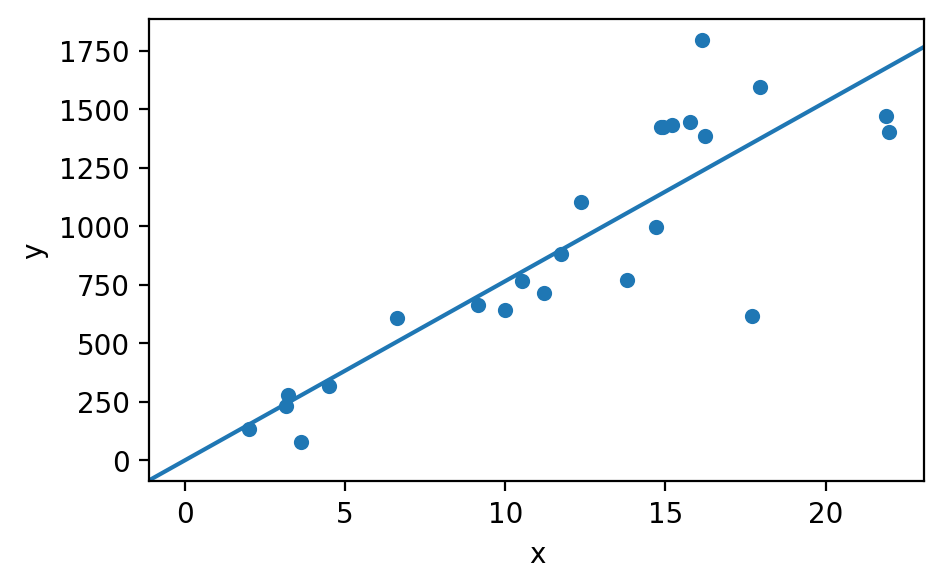

In [23]:
hubble.plot.scatter(x='x', y='y', figsize=(5,3))
plt.axline((0,0), slope=ols.params['x'])
plt.show()

## 담배 가격과 판매량

In [24]:
Cigar = pd.read_csv('csv/Ecdat/Cigar.csv')
Cigar90 = Cigar[Cigar.year==90].copy()
ols = smf.ols('np.log(sales)~np.log(price)', data=Cigar90).fit()
ols.params

Intercept        9.081182
np.log(price)   -0.899229
dtype: float64

## 재정자립도 회귀에서 맞춘값 그림

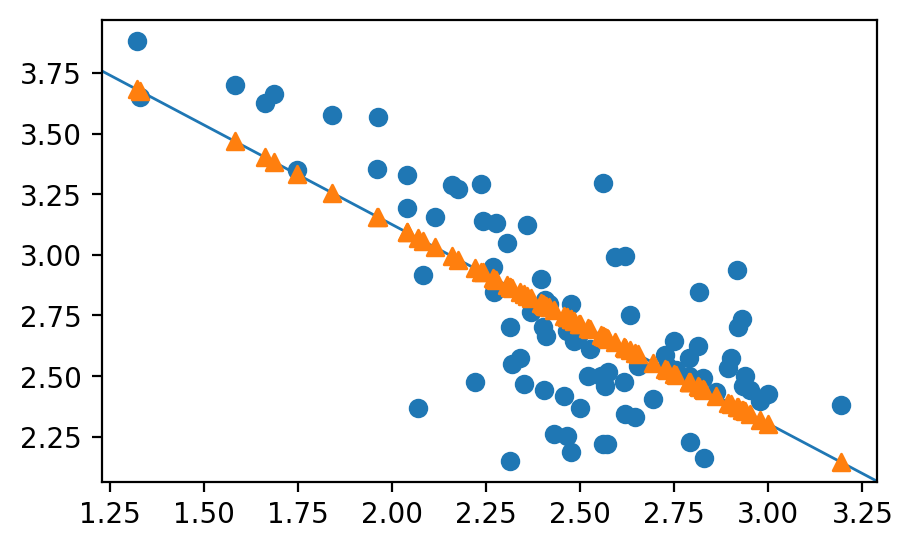

In [25]:
ols = smf.ols('np.log(finind)~np.log(servpc)', data = Pubserv1).fit()
b0,b1 = ols.params
plt.figure(figsize=(5,3))
plt.scatter(np.log(Pubserv1.servpc), np.log(Pubserv1.finind), zorder=1)
plt.fix_lims()
plt.axline((0,b0), slope=b1, linewidth=1, zorder=2)
plt.scatter(np.log(Pubserv1.servpc), ols.fittedvalues, marker = '^', zorder=3)
plt.show()

## 잔차합, 설명변수와 잔차의 곱의 합, 맞춘값과 잔차의 곱의 합

In [26]:
print(f"Sum of residuals = {np.sum(ols.resid)}")
print(f"Sum of x*uhat    = {np.sum(ols.resid*np.log(Pubserv1.servpc))}")
print(f"Sum of yhat*uhat = {np.sum(ols.fittedvalues*ols.resid)}")

Sum of residuals = 9.547918011776346e-14
Sum of x*uhat    = 2.5029978090174154e-13
Sum of yhat*uhat = 2.485095462745335e-13


## OLS 회귀결과 요약(R제곱 포함)

In [27]:
ols.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(finind)   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.548
No. Observations:                  84   F-statistic:                     101.5
Covariance Type:            nonrobust   Prob (F-statistic):           5.27e-16
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.7675      0.202     23.559      0.000       4.365       5.170
np.log(servpc)    -0.8212      0.081    -10.076      0.000      -0.983      -0.659
==================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## SSE/SST = R-squared

아래 두 값은 동일하다.

In [28]:
print((ols.ess/ols.centered_tss, ols.rsquared))

(0.5532173833344799, 0.55321738333448)


## SST = SSE + SSR

아래에서 첫 번째 원소는 SST, 두 번째 원소는 SSE + SSR이다. 둘은 서로 같다.

In [29]:
ols.centered_tss, ols.ess + ols.ssr

(14.37053822736247, 14.37053822736247)

## 예제 3.1 단위 변환의 유용성

In [30]:
smf.ols('co2pc~gdppcppp', data = Ekc).fit().params

Intercept   -0.034195
gdppcppp     0.000339
dtype: float64

설명변수를 1000으로 나눈 후 회귀하면, 원래 계수추정치에 1000을 곱한 값이 새로운 추정치가 된다.

In [31]:
smf.ols('co2pc~I(gdppcppp/1000)', data = Ekc).fit().params

Intercept            -0.034195
I(gdppcppp / 1000)    0.339048
dtype: float64

## 로그와 측정단위 변환

In [32]:
smf.ols('np.log(co2pc)~np.log(gdppcppp)', data = Ekc).fit().params

Intercept          -10.283620
np.log(gdppcppp)     1.224789
dtype: float64

설명변수가 로그 형태인 경우 설명변수를 1000으로 나누어도 절편 추정치만 영향을 받는다.

In [33]:
smf.ols('np.log(co2pc)~np.log(gdppcppp/1000)', data = Ekc).fit().params

Intercept                 -1.823079
np.log(gdppcppp / 1000)    1.224789
dtype: float64